In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
TrainingImagePath='./processed'

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)
dir_Iterator = datagen.flow_from_directory(
    TrainingImagePath,
    batch_size=32,
    save_format="jpg",
    target_size=(256, 256),
)
for i in range(10):
    img, label = dir_Iterator.next()
    print(img.shape, label)
    plt.imshow(img[0])
    plt.show()

training_set=dir_Iterator

## Load data and divide into train and test sets

In [9]:
TrainingImagePath='./processed';
# Loading dataset without augmentation
training_set = tf.keras.preprocessing.image_dataset_from_directory(
    TrainingImagePath,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(256, 256),
    batch_size=32,
)

testing_set = tf.keras.preprocessing.image_dataset_from_directory(
    TrainingImagePath,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(256, 256),
    batch_size=32,
)



Found 16 files belonging to 2 classes.
Using 13 files for training.
Found 16 files belonging to 2 classes.
Using 3 files for validation.


In [10]:
class_names = training_set.class_names
print(class_names)

['khalil', 'others']


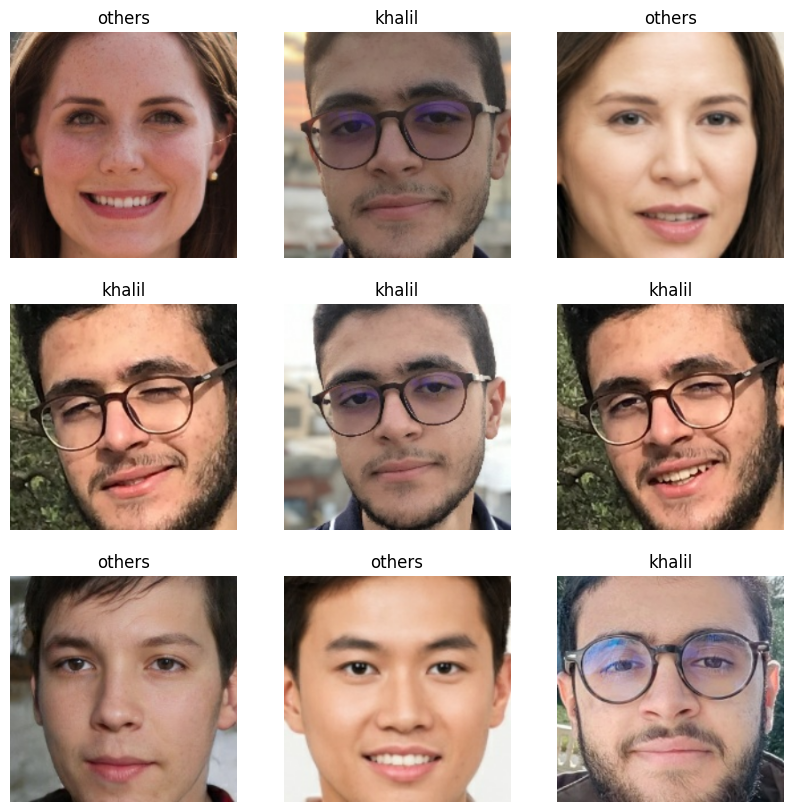

In [7]:
# Visualizing the data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in training_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Standardize the data

In [14]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = training_set.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.89529055


A basic Keras model

In [22]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(256, 256, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Compile the model

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)       

Train the model (Train the model for 10 epochs with the Keras Model.fit method)



In [24]:
epochs=10
history = model.fit(
  training_set,
  validation_data=testing_set,
  epochs=epochs
)

Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.6829 - accuracy: 0.6154 - val_loss: 10.0813 - val_accuracy: 0.3333
Epoch 2/10
1/1 [==============================] - 1s 538ms/step - loss: 5.4280 - accuracy: 0.6154 - val_loss: 1.1100 - val_accuracy: 0.3333
Epoch 3/10
1/1 [==============================] - 1s 523ms/step - loss: 0.5918 - accuracy: 0.6154 - val_loss: 1.1382 - val_accuracy: 0.6667
Epoch 4/10
1/1 [==============================] - 1s 532ms/step - loss: 2.0161 - accuracy: 0.3846 - val_loss: 0.8937 - val_accuracy: 0.6667
Epoch 5/10
1/1 [==============================] - 1s 528ms/step - loss: 1.5093 - accuracy: 0.3846 - val_loss: 0.6792 - val_accuracy: 0.6667
Epoch 6/10
1/1 [==============================] - 1s 549ms/step - loss: 0.9930 - accuracy: 0.3846 - val_loss: 0.6228 - val_accuracy: 0.6667
Epoch 7/10
1/1 [==============================] - 1s 535ms/step - loss: 0.6908 - accuracy: 0.3846 - val_loss: 0.7128 - val_accuracy: 0.3333
Epoch 8/10
1/1 [======

Visualize training results

In [35]:
im_path='others15.jpg'

img = tf.keras.utils.load_img(
    im_path, target_size=(256, 256)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 34ms/step
This image most likely belongs to khalil with a 66.97 percent confidence.
